## Build U-NET++ semantic segmentation model using PyTorch 🔥

### Datasets and DataLoaders

In [6]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision


from common.constants import NODATA_FLOAT32


torch.manual_seed(666)


class LabeledS2Dataset(Dataset):
    def __init__(self, root_dir, sub_dir):
        self.data_dir = f'{root_dir}/{sub_dir}'
        self.image_paths = glob.glob(f'{self.data_dir}/images/*.tif')
        self.label_paths = glob.glob(f'{self.data_dir}/labels/*.tif')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        
        image_path = self.image_paths[index]
        label_path = self.label_paths[index]

        with rasterio.open(image_path) as src:
            image = src.read()
            # image[image == NODATA_FLOAT32] = -0.01
            # handle nodata here...
            image = torch.from_numpy(image)

        with rasterio.open(label_path) as src:
            label = src.read()
            # label[label == 0] = 0
            label = torch.from_numpy(label).long()

        return image, label    
    

train_dataset = LabeledS2Dataset(root_dir='./data/trainingData', sub_dir='train')
train_dataloader = DataLoader(train_dataset, batch_size=2, num_workers=0, shuffle=True)

test_dataset = LabeledS2Dataset(root_dir='./data/trainingData', sub_dir='test')
test_dataloader = DataLoader(test_dataset, batch_size=2, num_workers=0, shuffle=True)

val_dataset = LabeledS2Dataset(root_dir='./data/trainingData', sub_dir='val')
val_dataloader = DataLoader(val_dataset, batch_size=2, num_workers=0, shuffle=True)


In [53]:
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils
import torch.optim as optim


# make sure this is in sync with create patches
CLASSES = {
    'unclassified': 0,
    'agriculture': 10,
    'bare_dark': 5,
    'bare_light': 4,
    'built': 6,
    'burn': 9,
    'cloud': 1,
    'flooded_vegetation': 3,
    'grass_dry': 12,
    'grass_verdant': 11,
    'shrubs': 8,
    'trees': 7,
    'water': 2
}

CLASS_NAMES = list(CLASSES.keys())
CLASS_INDEXES = list(CLASSES.values())
DEVICE = 'cuda'

model = smp.UnetPlusPlus(
    encoder_name='vgg16', # resnet18, resnet50, vgg16
    encoder_depth=5, 
    encoder_weights='imagenet', 
    decoder_use_batchnorm=True, 
    decoder_channels=(256, 128, 64, 32, 16), 
    decoder_attention_type=None,
    in_channels=4, 
    classes=len(CLASS_NAMES), 
    activation=None, 
    aux_params=None
)


# loss = smp.losses.DiceLoss(mode="multiclass")
# loss.__name__ = 'Dice_loss'

# loss = smp.losses.JaccardLoss(mode="multiclass")
# loss.__name__ = 'Jaccard_loss'

loss = smp.losses.TverskyLoss(mode="multiclass")
loss.__name__ = "Tversky_loss"

optimizer = optim.Adam(params=model.parameters(), lr=0.001)

metrics = []


In [54]:
train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss,
    metrics= metrics,
    optimizer=optimizer,
    verbose=True,
)

test_epoch = smp_utils.train.ValidEpoch(
    model, 
    loss=loss,
    metrics=metrics,
    verbose=True,
)

In [55]:
max_score = 0


for i in range(0, 2):
    train_logs = train_epoch.run(train_dataloader)
    test_logs = test_epoch.run(test_dataloader)
    torch.save(model, './best_model.pth')
    
print('done')

valid: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it, Tversky_loss - 0.14]
done


In [56]:

best_model = torch.load('./best_model.pth')

val_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics
)

logs = val_epoch.run(val_dataloader)
print(logs)

valid: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it, Tversky_loss - 0.2947]
{'Tversky_loss': 0.2947365343570709}


torch.Size([4, 512, 512])
(1, 4, 512, 512)
labels [4 5 7 8 --]
prediction [1 2 3 4 5 6 7 8 9 10 11 12 --]


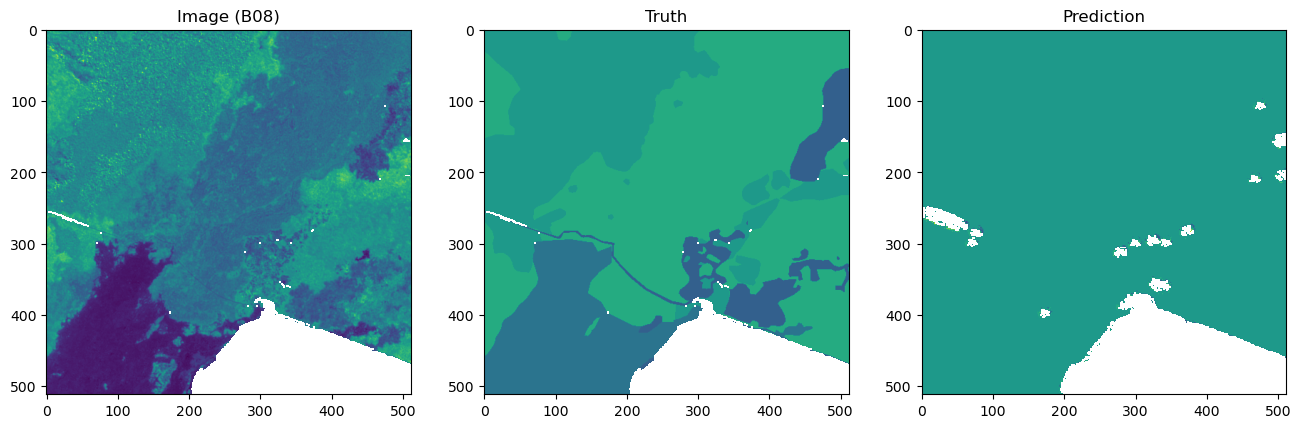

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn


count = 1

fig, rows = plt.subplots(count, 3, figsize=(16, 8))
if rows.ndim == 1:
    rows = np.expand_dims(rows, 0)
    

for i in range(count):
            
    row = rows[i]    
    image, labels = train_dataset[i+2] #val_dataset[i]       
    
    print(image.shape)
    
    image = np.expand_dims(image, 0) 
    
    print(image.shape)
    
    image = torch.tensor(image)

    prediction = best_model.predict(image)
    
    softmax = nn.Softmax(dim=1)
    probabilities = softmax(prediction)    
    
    prediction = torch.argmax(probabilities, dim=1).squeeze(1)
    prediction = (prediction.squeeze().cpu().numpy().round())
    prediction = np.ma.array(prediction, mask=(prediction==0))

    labels = labels.squeeze().numpy()    
    labels = np.ma.array(labels, mask=(labels==0))
    
    print('labels', np.unique(labels))
    print('prediction', np.unique(prediction))
    
    nir_data = image.squeeze()[3].numpy()
    nir_data = np.ma.array(nir_data, mask=(nir_data==NODATA_FLOAT32))
    
    row[0].imshow(nir_data)
    row[0].set_title('Image (B08)')
    
    row[1].imshow(labels, vmin=0, vmax=13)
    row[1].set_title('Truth')
    

    row[2].imshow(prediction, vmin=0, vmax=13)
    row[2].set_title('Prediction')
    
    

In [ ]:

import matplotlib.pyplot as plt
import rasterio
import torch
import torch.nn as nn

from common.utilities.visualization import plot_bands



composite_path = "./data/20220701_20220901_south/composite.tif"
with rasterio.open(composite_path) as src:
    data = src.read()

height, width = data.shape[1], data.shape[2]
new_height = (height // 32) * 32
new_width = (width // 32) * 32
data = data[:, :new_height, :new_width]

image = np.expand_dims(data, 0)   
image = torch.tensor(image)

best_model = torch.load('./best_model.pth')
prediction = best_model.predict(image)

softmax = nn.Softmax(dim=1)
probabilities = softmax(prediction)    

prediction = torch.argmax(probabilities, dim=1).squeeze(1)
prediction = (prediction.squeeze().cpu().numpy().round())
prediction = np.ma.array(prediction, mask=(prediction==0))


fig, (ax1, ax2) = plt.subplots(count, 2, figsize=(16, 8))


plot_bands(data, bands=[2, 1, 0], ax=ax1, transpose=True)

